#### 线性回归从零开始实现

In [3]:
import random
import torch
from d2l import torch as d2l

In [4]:
# 合成数据集
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+ϵ的数据"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print("features:", features[0], "\nlabel:", labels[0])

features: tensor([0.0555, 0.9877]) 
label: tensor([0.9647])


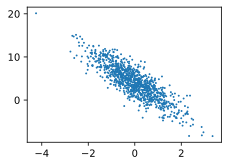

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]    # 生成器

In [9]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.0736,  1.3698],
        [ 0.6373, -0.1250],
        [ 1.2912,  0.5236],
        [ 0.7657, -1.0580],
        [ 1.3401,  0.0619],
        [-0.6520,  0.3440],
        [ 0.7433, -4.2456],
        [ 0.2811,  0.2603],
        [-0.8915, -1.1729],
        [ 1.8417, -0.4881]]) 
 tensor([[-0.6152],
        [ 5.8886],
        [ 5.0076],
        [ 9.3361],
        [ 6.6636],
        [ 1.7144],
        [20.1215],
        [ 3.8736],
        [ 6.4075],
        [ 9.5335]])


In [10]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [11]:
def linreg(X, w, b):    #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [12]:
def squared_loss(y_hat, y):     #@save
    """均方损失"""
    return (y_hat - y) ** 2 /2

In [13]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [14]:
lr = 0.03           # 学习率
num_epochs = 3     # 迭代次数
net = linreg        # 模型
loss = squared_loss # 损失

In [18]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)   # X和y的小批量损失
        # l的形状是(batch_size, 1)，而不是一个标量，l中所有的元素被加到一起
        l.sum().backward()  # 计算关于[w, b]的梯度
        sgd([w, b], lr, batch_size)     # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.042979
epoch 2, loss 0.000169
epoch 3, loss 0.000052


In [21]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 1.5374e-03, -1.6689e-06], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0009], grad_fn=<RsubBackward1>)


In [22]:
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 20
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 1.3401,  0.0619],
         [-0.7587, -0.5415],
         [ 1.1577, -0.1675],
         [-0.8045, -0.2158],
         [ 0.4775, -1.7194],
         [ 0.9249,  0.8265],
         [-1.6207,  0.6318],
         [ 0.7828,  0.7491],
         [ 1.5896, -1.5429],
         [-0.1152, -0.0231],
         [ 0.7676, -0.0037],
         [-0.6573, -0.5810],
         [ 1.2891,  0.7934],
         [-0.1743, -0.3672],
         [-0.2453,  0.3982],
         [-0.9633,  1.0728],
         [-1.5117,  0.2689],
         [-0.0962,  2.4453],
         [ 1.4109,  0.1871],
         [ 0.3431,  0.0096]]),
 tensor([[ 6.6636],
         [ 4.5253],
         [ 7.0855],
         [ 3.3367],
         [11.0049],
         [ 3.2477],
         [-1.1850],
         [ 3.2187],
         [12.6258],
         [ 4.0466],
         [ 5.7727],
         [ 4.8677],
         [ 4.0789],
         [ 5.0940],
         [ 2.3563],
         [-1.3645],
         [ 0.2514],
         [-4.3056],
         [ 6.4087],
         [ 4.8746]])]

In [24]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.1)
net[0].bias.data.fill_(0)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        # forwad
        output = net(X)
        loss = criterion(output, y)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    l = criterion(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.075949
epoch 2, loss 0.000290
epoch 3, loss 0.000103


In [25]:
w = net[0].weight.data
print('w的估计误差：', true_w-w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b-b)

w的估计误差： tensor([ 8.4531e-04, -4.3392e-05])
b的估计误差： tensor([0.0007])


In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)